In [1]:
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy
from matplotlib import pyplot
from jax.config import config
config.update("jax_enable_x64", True)

sys.path.append('../../timeseries_jax/')
sys.path.append('../../timeseries/experiments_scripts/')
sys.path.append('../../src_jax/')

from jax import numpy as jnp
import factor
import state_model
import observation_model
from ssm_em import StateSpaceEM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM, load_model
from sklearn.covariance import EmpiricalCovariance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from exp_utils import *
import ssm
import statsmodels.api as sm

'''
sys.path.append('../../timeseries/kalman-jax-master')
from jax.experimental import optimizers
#from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot
'''


class PredictiveDensity:
    def __init__(self, mu, sigma):
        if mu.ndim == 1:
            self.mu = np.array([mu]).T
        else:
            self.mu = np.array(mu)
        if sigma.ndim == 1:
            self.Sigma = np.array([sigma]).T
        else:    
            self.Sigma = np.array(sigma)
            
def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def train_linear_SSM(x_tr, dz):

    dx = x_tr.shape[1]
    sm = state_model.LinearStateModel(dz)
    om = observation_model.LinearObservationModel(dx, dz)
        
    ssm_em_lin = StateSpaceEM(jnp.array(x_tr), observation_model=om, state_model=sm)
    ssm_em_lin.run()
    
    return ssm_em_lin


def train_linear_hsk_SSM(x_tr, dz, du, init_lin_model):

    dx = x_tr.shape[1]
    sm_hs = state_model.LinearStateModel(dz)
    om_hs = observation_model.HCCovObservationModel(dx, dz, du)
    if init_lin_model == 1:
        ssm_lin = train_linear_SSM(x_tr, dz)
        om_hs.lin_om_init(ssm_lin.om)
    hs_model = StateSpaceEM(jnp.array(x_tr), observation_model=om_hs, state_model=sm_hs)
    hs_model.run()
    return hs_model

def train_nonlinear_SSM(x_tr, dz, **kwargs):
    '''
    to be updated; currently doesn't run
    LSEMStateModel -> sm_hs = state_model.LSEMStateModel(args.dz,args.dk# + param for basis func)
    '''
    nonlin_model = NonLinearStateSpace_EM(x_tr,args.dz, args.dk)
    nonlin_model.run()
    
    return nonlin_model

class HMM_class:
    
    def __init__(self, x_tr, K, obs_model='gaussian'):
        self.x_tr = x_tr
        self.D = x_tr.shape[1]
        self.K = K
        self.obs_model = obs_model
        self.model = self._train()
        
    def _train(self):
        model = ssm.HMM(self.K, self.D, observations=self.obs_model)
        model.fit(self.x_tr, method="em")
        return model

    def compute_predictive_log_likelihood(self, x_te):
        return self.model.log_likelihood(x_te)
    
    def compute_predictive_density(self, x_te):
        mask = np.logical_not(np.isnan(x_te))
        x_te_not_nan = np.zeros(x_te.shape)
        x_te_not_nan[mask] = x_te[mask]
        states = self.model.filter(x_te_not_nan, mask=mask)
        if self.obs_model == 'gaussian' or  self.obs_model == 'studentst':
            mean_te = np.dot(states, self.model.observations.mus)
        elif self.obs_model == 'ar':
            mean_te = np.sum(states[:,:,None] * (np.sum(self.model.observations.As[None] * x_te[:,None, None], axis=3) + self.model.observations.bs), axis=1)
        std_te = np.dot(states, np.sqrt(self.model.observations.Sigmas.diagonal(axis1=1, axis2=2)))
        print(mean_te.shape, std_te.shape)
        return PredictiveDensity(mean_te, std_te ** 2)

def train_HMM(x_tr, num_states, **kwargs):
    return HMM_class(x_tr, num_states)


class ARIMAX:
    
    def __init__(self, x_tr, p, q):
        self.x_tr = x_tr
        self.p = p
        self.q = q
        self._train()
        
    def _train(self):
        if x_tr.shape[1] == 1:
            self.mod = sm.tsa.statespace.SARIMAX(x_tr, trend='c', order=(self.p,0,self.q))
            self.fit_res = self.mod.fit(disp=False)
        else:
            self.mod = sm.tsa.VARMAX(x_tr, trend='c', order=(self.p,self.q))
            self.fit_res = self.mod.fit(disp=False, max_iter=1000)
            
    def compute_predictive_density(self, x_te):
        mod_te = self.mod.clone(x_te)
        res = mod_te.filter(self.fit_res.params)
        predict = res.get_prediction()
        predict_ci = predict.conf_int(alpha=1.-.68)
        mu = predict.predicted_mean
        if x_te.shape[1] == 1:
            std = predict.predicted_mean - predict_ci[:,0]
        else:
            std = predict.predicted_mean - predict_ci[:,:x_te.shape[1]]
        return PredictiveDensity(mu, std ** 2)
            
    def compute_predictive_log_likelihood(self, x_te):  
        mod_te = self.mod.clone(x_te)
        return mod_te.loglike(self.fit_res.params)
    
def train_arimax(x_tr, p, q,**kwargs):
    
    arimax_model = ARIMAX(x_tr, p, q)
    return arimax_model

In [2]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te_original, x_te_na, s_tr_x = load_energy_e1(train_ratio=.75)
dz = 4
ssm_em_lin = train_linear_SSM(x_tr, dz)

Iteration 1 - llk=-6351.4
Iteration 2 - llk=-2907.7
Iteration 3 - llk=-2247.1
Iteration 4 - llk=-1706.5
Iteration 5 - llk=-1324.4
Iteration 6 - llk=-1084.4
Iteration 7 - llk=-954.2
Iteration 8 - llk=-889.8
Iteration 9 - llk=-856.6
Iteration 10 - llk=-836.4
Iteration 11 - llk=-821.8
Iteration 12 - llk=-810.0
Iteration 13 - llk=-800.2
Iteration 14 - llk=-791.9
Iteration 15 - llk=-784.8
Iteration 16 - llk=-778.6
Iteration 17 - llk=-773.2
Iteration 18 - llk=-768.5
Iteration 19 - llk=-764.3
Iteration 20 - llk=-760.6
Iteration 21 - llk=-757.4
Iteration 22 - llk=-754.4
Iteration 23 - llk=-751.8
Iteration 24 - llk=-749.5
Iteration 25 - llk=-747.3
Iteration 26 - llk=-745.4
Iteration 27 - llk=-743.7
Iteration 28 - llk=-742.1
Iteration 29 - llk=-740.6
Iteration 30 - llk=-739.3
Iteration 31 - llk=-738.1
Iteration 32 - llk=-736.9
Iteration 33 - llk=-735.9
Iteration 34 - llk=-734.9
Iteration 35 - llk=-734.0
Iteration 36 - llk=-733.2
Iteration 37 - llk=-732.4
Iteration 38 - llk=-731.7
EM did converge

In [3]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te_original, x_te_na, s_tr_x = load_energy_e1(train_ratio=.75)
dz = 4
du = 3
ssm_em_hsk = train_linear_hsk_SSM(x_tr, dz, du, init_lin_model=True)

Iteration 1 - llk=-6351.4
Iteration 2 - llk=-2907.7
Iteration 3 - llk=-2247.1
Iteration 4 - llk=-1706.5
Iteration 5 - llk=-1324.4
Iteration 6 - llk=-1084.4
Iteration 7 - llk=-954.2
Iteration 8 - llk=-889.8
Iteration 9 - llk=-856.6
Iteration 10 - llk=-836.4
Iteration 11 - llk=-821.8
Iteration 12 - llk=-810.0
Iteration 13 - llk=-800.2
Iteration 14 - llk=-791.9
Iteration 15 - llk=-784.8
Iteration 16 - llk=-778.6
Iteration 17 - llk=-773.2
Iteration 18 - llk=-768.5
Iteration 19 - llk=-764.3
Iteration 20 - llk=-760.6
Iteration 21 - llk=-757.4
Iteration 22 - llk=-754.4
Iteration 23 - llk=-751.8
Iteration 24 - llk=-749.5
Iteration 25 - llk=-747.3
Iteration 26 - llk=-745.4
Iteration 27 - llk=-743.7
Iteration 28 - llk=-742.1
Iteration 29 - llk=-740.6
Iteration 30 - llk=-739.3
Iteration 31 - llk=-738.1
Iteration 32 - llk=-736.9
Iteration 33 - llk=-735.9
Iteration 34 - llk=-734.9
Iteration 35 - llk=-734.0
Iteration 36 - llk=-733.2
Iteration 37 - llk=-732.4
Iteration 38 - llk=-731.7
EM did converge

In [4]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te_original, x_te_na, s_tr_x = load_energy_e1(train_ratio=.75)
K = 17
hmm = train_HMM(x_tr, K)

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te_original, x_te_na, s_tr_x = load_energy_e1(train_ratio=.75)
p, q = 7, 5
arimax = train_arimax(x_tr, p, q)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
T_start = 10
T_stop = 457
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te_original, x_te_na, s_tr_x = load_energy_e1(train_ratio=.75)
lin_pred_density = ssm_em_lin.compute_predictive_density(x_te_original)
lb_lin, ub_lin = lin_pred_density.mu[T_start:T_stop] - 1.68 * np.sqrt(lin_pred_density.Sigma[T_start:T_stop].diagonal(axis1=1, axis2=2)), lin_pred_density.mu[T_start:T_stop] + 1.68 * np.sqrt(lin_pred_density.Sigma[T_start:T_stop].diagonal(axis1=1, axis2=2))
lb_lin, ub_lin = s_tr_x.inverse_transform(lb_lin), s_tr_x.inverse_transform(ub_lin)
lb_lin[:,[0,2,3]] = np.logaddexp(1, lb_lin[:,[0,2,3]])
ub_lin[:,[0,2,3]] = np.logaddexp(1, ub_lin[:,[0,2,3]])
hsk_pred_density = ssm_em_hsk.compute_predictive_density(x_te_original)
lb_hsk, ub_hsk = hsk_pred_density.mu[T_start:T_stop] - 1.68 * np.sqrt(hsk_pred_density.Sigma[T_start:T_stop].diagonal(axis1=1, axis2=2)), hsk_pred_density.mu[T_start:T_stop] + 1.68 * np.sqrt(hsk_pred_density.Sigma[T_start:T_stop].diagonal(axis1=1, axis2=2))
lb_hsk, ub_hsk = s_tr_x.inverse_transform(lb_hsk), s_tr_x.inverse_transform(ub_hsk)
lb_hsk[:,[0,2,3]] = np.logaddexp(1, lb_hsk[:,[0,2,3]])
ub_hsk[:,[0,2,3]] = np.logaddexp(1, ub_hsk[:,[0,2,3]])
hmm_pred_density = hmm.compute_predictive_density(x_te_original)
lb_hmm, ub_hmm = hmm_pred_density.mu[T_start:T_stop] - 1.68 * np.sqrt(hmm_pred_density.Sigma[T_start:T_stop]), hmm_pred_density.mu[T_start:T_stop] + 1.68 * np.sqrt(hmm_pred_density.Sigma[T_start:T_stop])
lb_hmm, ub_hmm = s_tr_x.inverse_transform(lb_hmm), s_tr_x.inverse_transform(ub_hmm)
lb_hmm[:,[0,2,3]] = np.logaddexp(1, lb_hmm[:,[0,2,3]])
ub_hmm[:,[0,2,3]] = np.logaddexp(1, ub_hmm[:,[0,2,3]])
arimax_pred_density = arimax.compute_predictive_density(x_te_original)
lb_arimax, ub_arimax = arimax_pred_density.mu[T_start:T_stop] - 1.68 * np.sqrt(arimax_pred_density.Sigma[T_start:T_stop]), arimax_pred_density.mu[T_start:T_stop] + 1.68 * np.sqrt(arimax_pred_density.Sigma[T_start:T_stop])
lb_arimax, ub_arimax = s_tr_x.inverse_transform(lb_arimax), s_tr_x.inverse_transform(ub_arimax)
lb_arimax[:,[0,2,3]] = np.logaddexp(1, lb_arimax[:,[0,2,3]])
ub_arimax[:,[0,2,3]] = np.logaddexp(1, ub_arimax[:,[0,2,3]])

(457, 4) (457, 4)


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [7]:
from timeseries_data import load_opsd_data
raw_data = load_opsd_data().iloc[-x_te_original.shape[0]:]
date = raw_data.index
tick_idx = np.where(date.is_month_start)[0]
tick_labels = []
for i, idx in enumerate(tick_idx):
    label = date[idx].month_name()[:3] + str(date[idx].year)[-2:]
    tick_labels.append(label)
tick_labels

['Oct18',
 'Nov18',
 'Dec18',
 'Jan19',
 'Feb19',
 'Mar19',
 'Apr19',
 'May19',
 'Jun19',
 'Jul19',
 'Aug19',
 'Sep19',
 'Oct19',
 'Nov19',
 'Dec19']

In [13]:
raw_data.columns

Index(['DE_solar_generation_actual', 'DE_temperature',
       'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal'],
      dtype='object')

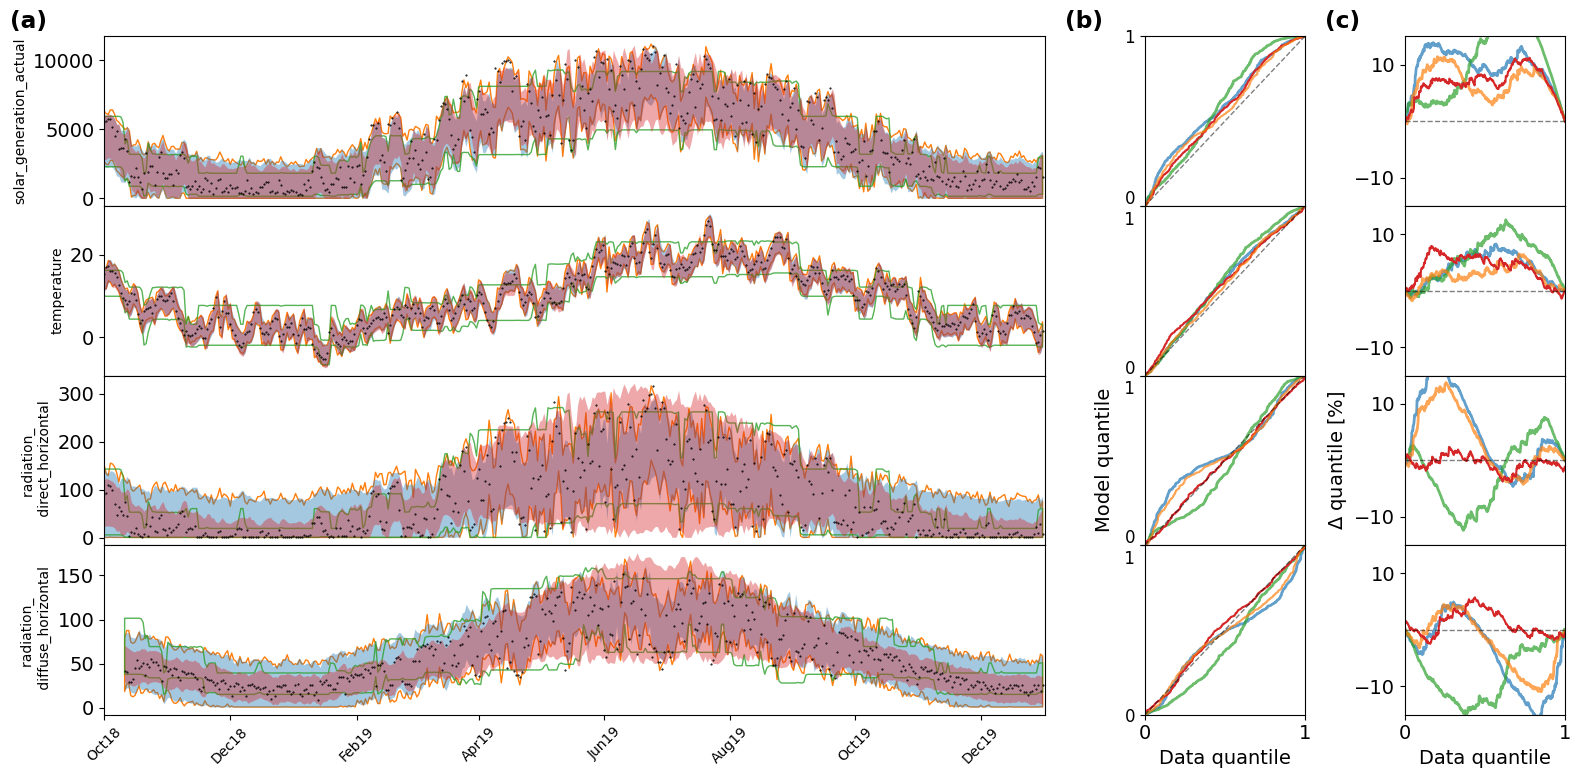

In [8]:
pyplot.rcdefaults()
pyplot.rc('font', size = 14)
fig = pyplot.figure(figsize=(16,8))
gs = fig.add_gridspec(4, 6, hspace=0)

x_te_plot = s_tr_x.inverse_transform(x_te_original)
x_te_plot[:,[0,2,3]] = np.logaddexp(1, x_te_plot[:,[0,2,3]])

for dx in range(ssm_em_lin.Dx):
    ax1 = fig.add_subplot(gs[dx,:4])
    ax1.plot(range(T_start,T_stop), x_te_plot[T_start:T_stop, dx], 'k.', ms=1)
    ax1.fill_between(range(T_start,T_stop), lb_arimax[:,dx], ub_arimax[:,dx], color='C1', facecolor='none', alpha=1, lw=1)
    ax1.fill_between(range(T_start,T_stop), lb_lin[:,dx], ub_lin[:,dx], color='C0', alpha=.4, lw=0)
    ax1.fill_between(range(T_start,T_stop), lb_hmm[:,dx], ub_hmm[:,dx], color='C2', facecolor='none', alpha=.8, lw=1)
    ax1.fill_between(range(T_start,T_stop), lb_hsk[:,dx], ub_hsk[:,dx], color='C3', alpha=.4, lw=0)
    ax1.set_xlim([T_start,T_stop])
    ax1.set_xticks([])
    #ax1.set_yticks([])
    if dx >= 2:
        ax1.set_ylabel(raw_data.columns[dx][3:13] + ' \n ' + raw_data.columns[dx][13:], fontsize=10)
    else:
        ax1.set_ylabel(raw_data.columns[dx][3:], fontsize=10)
    
    
    ax2 = fig.add_subplot(gs[dx,4])
    hsk_cdf = np.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - hsk_pred_density.mu[:,dx]) / np.sqrt(hsk_pred_density.Sigma[:,dx,dx])))
    lin_cdf = np.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - lin_pred_density.mu[:,dx]) / np.sqrt(lin_pred_density.Sigma[:,dx,dx])))
    hmm_cdf = np.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - hmm_pred_density.mu[:,dx]) / np.sqrt(hmm_pred_density.Sigma[:,dx])))
    arimax_cdf = np.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - arimax_pred_density.mu[:,dx]) / np.sqrt(arimax_pred_density.Sigma[:,dx])))
    ax2.plot(np.linspace(0,1,x_te_original.shape[0]), lin_cdf, color='C0', alpha=.7, lw=2)
    ax2.plot(np.linspace(0,1,x_te_original.shape[0]), hmm_cdf, color='C2', alpha=.7, lw=2)
    ax2.plot(np.linspace(0,1,x_te_original.shape[0]), hsk_cdf, color='C3', alpha=1)
    ax2.plot(np.linspace(0,1,x_te_original.shape[0]), arimax_cdf, color='C1', alpha=.7)
    ax2.plot([0,1], [0,1], 'k--', lw=1., alpha=.5)
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])
    ax2.set_xticks([])
    ax2.set_yticks([0,1])
    if dx == 0:
        ax2.set_yticklabels(labels=['','1'], fontsize=12)
    else:
        ax2.set_yticklabels(labels=['','0\n 1'], fontsize=12)
    
    ax3 = fig.add_subplot(gs[dx,5])
    ax3.plot(np.linspace(0,1,x_te_original.shape[0]), 100 * (lin_cdf - np.linspace(0,1,x_te_original.shape[0])), color='C0', alpha=.7, lw=2)
    ax3.plot(np.linspace(0,1,x_te_original.shape[0]), 100 * (hmm_cdf - np.linspace(0,1,x_te_original.shape[0])), color='C2', alpha=.7, lw=2)
    ax3.plot(np.linspace(0,1,x_te_original.shape[0]), 100 * (arimax_cdf - np.linspace(0,1,x_te_original.shape[0])), color='C1', alpha=.7, lw=2)
    ax3.plot(np.linspace(0,1,x_te_original.shape[0]), 100 * (hsk_cdf - np.linspace(0,1,x_te_original.shape[0])), color='C3')
    ax3.plot([0,1], [0,0], 'k--', lw=1., alpha=.5)
    ax3.set_xlim([0,1])
    #ax2.set_ylim([0,1])
    ax3.set_xticks([])
    ax3.set_yticks([-10,10])
    ax3.set_ylim([-15,15])
    if dx == 2:
        ax2.set_ylabel('Model quantile')
        ax3.set_ylabel('$\Delta$ quantile [%]')
    if dx == 0:
        ax1.set_title('(a)', loc='left', fontweight='bold', x=-.1)
        ax2.set_title('(b)', loc='left', fontweight='bold', x=-.5)
        ax3.set_title('(c)', loc='left', fontweight='bold', x=-.5)

#ax1.set_xlabel('Timesteps')
ax1.set_xticks(tick_idx[::2])
ax1.set_xticklabels(tick_labels[::2], rotation=45, fontsize=10)
ax2.set_xticks([0,1])
ax3.set_xticks([0,1])
ax2.set_xticks([0,1])
ax2.set_xlabel('Data quantile')
ax2.set_yticklabels(labels=['0','0\n 1'], fontsize=12)
ax3.set_xlabel('Data quantile')
pyplot.tight_layout()
fig.savefig('../../figs/aistats22/energy.pdf')
fig.savefig('../../figs/aistats22/energy.png', dpi=600)

In [41]:
x_te = x_te_original
x_te_nan = np.copy(x_te)
index_miss = 3
x_te_nan[:,index_miss] = np.nan
hmm_pred_density = hmm.compute_predictive_density(x_te_nan)
hsk_pred_density = ssm_em_hsk.compute_predictive_density(x_te_nan)
lin_pred_density = ssm_em_lin.compute_predictive_density(x_te_nan)
softp = lambda x: np.logaddexp(0,x)
x_te_rescaled = softp(s_tr_x.inverse_transform(x_te))
hmm_lb, hmm_ub = softp(s_tr_x.inverse_transform(hmm_pred_density.mu - 1.68 * np.sqrt(hmm_pred_density.Sigma))[:,index_miss]), softp(s_tr_x.inverse_transform(hmm_pred_density.mu + 1.68 * np.sqrt(hmm_pred_density.Sigma))[:,index_miss])
lin_lb, lin_ub = softp(s_tr_x.inverse_transform(lin_pred_density.mu - 1.68 * np.sqrt(lin_pred_density.Sigma.diagonal(axis1=1,axis2=2)))[:,index_miss]), softp(s_tr_x.inverse_transform(lin_pred_density.mu + 1.68 * np.sqrt(lin_pred_density.Sigma.diagonal(axis1=1,axis2=2)))[:,index_miss])
hsk_lb, hsk_ub = softp(s_tr_x.inverse_transform(hsk_pred_density.mu - 1.68 * np.sqrt(hsk_pred_density.Sigma.diagonal(axis1=1,axis2=2)))[:,index_miss]), softp(s_tr_x.inverse_transform(hsk_pred_density.mu + 1.68 * np.sqrt(hsk_pred_density.Sigma.diagonal(axis1=1,axis2=2)))[:,index_miss])
from timeseries_data import load_opsd_data
raw_data = load_opsd_data().iloc[-x_te.shape[0]:]
raw_data

date = raw_data.index
tick_idx = np.where(date.is_month_start)[0]
tick_labels = []
for i, idx in enumerate(tick_idx):
    label = date[idx].month_name()[:3] + str(date[idx].year)[-2:]
    tick_labels.append(label)
tick_labels

(457, 4) (457, 4)


['Oct18',
 'Nov18',
 'Dec18',
 'Jan19',
 'Feb19',
 'Mar19',
 'Apr19',
 'May19',
 'Jun19',
 'Jul19',
 'Aug19',
 'Sep19',
 'Oct19',
 'Nov19',
 'Dec19']

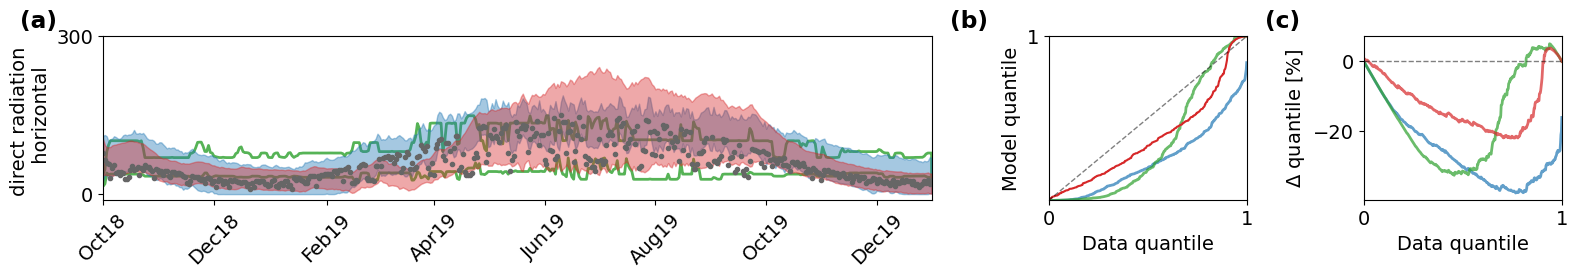

In [42]:
pyplot.rcdefaults()
pyplot.rc('font', size = 14)
fig = pyplot.figure(figsize=(16,3))
gs = fig.add_gridspec(1, 5)
ax1 = fig.add_subplot(gs[:3])
#ax1 = fig.add_subplot(111)
ax1.fill_between(range(hmm_lb.shape[0]), hmm_lb, hmm_ub, color='C2', facecolor='none', alpha=.8, lw=2)
ax1.fill_between(range(lin_lb.shape[0]), lin_lb, lin_ub, color='C0', alpha=.4)
ax1.fill_between(range(hsk_lb.shape[0]), hsk_lb, hsk_ub, color='C3', alpha=.4)
ax1.plot(range(hmm_lb.shape[0]), raw_data['DE_radiation_diffuse_horizontal'], color=[.4,.4,.4], marker='.', lw=0)
ax1.set_xticks(tick_idx[::2])
ax1.set_xticklabels(tick_labels[::2] , rotation=45)
ax1.set_xlim([0,x_te.shape[0]-1])
#ax1.set_ylim([0,12000])
ax1.set_yticks([0,300])
#ax1.set_yticklabels([0,10,20], fontsize=10)
ax1.set_ylabel('direct radiation \n horizontal')
ax2 = fig.add_subplot(gs[3])
dx = 3
hsk_cdf = np.sort(scipy.stats.norm.cdf((x_te[5:,dx] - hsk_pred_density.mu[5:,dx]) / np.sqrt(hsk_pred_density.Sigma[5:,dx,dx])))
lin_cdf = np.sort(scipy.stats.norm.cdf((x_te[5:,dx] - lin_pred_density.mu[5:,dx]) / np.sqrt(lin_pred_density.Sigma[5:,dx,dx])))
hmm_cdf = np.sort(scipy.stats.norm.cdf((x_te[5:,dx] - hmm_pred_density.mu[5:,dx]) / np.sqrt(hmm_pred_density.Sigma[5:,dx])))
ax2.plot(np.linspace(0,1,x_te.shape[0]-5), lin_cdf, color='C0', alpha=.7, lw=2)
ax2.plot(np.linspace(0,1,x_te.shape[0]-5), hmm_cdf, color='C2', alpha=.7, lw=2)
ax2.plot(np.linspace(0,1,x_te.shape[0]-5), hsk_cdf, color='C3', alpha=1)
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax2.plot([0,1], [0,1], 'k--', lw=1., alpha=.5)
ax2.set_ylabel('Model quantile')
ax2.set_xlabel('Data quantile')
ax2.set_xticks([0,1])
ax2.set_yticks([1])

ax3 = fig.add_subplot(gs[4])
ax3.plot(np.linspace(0,1,x_te.shape[0]-5), 100 * (lin_cdf - np.linspace(0,1,x_te.shape[0]-5)), color='C0', alpha=.7, lw=2)
ax3.plot(np.linspace(0,1,x_te.shape[0]-5), 100 * (hmm_cdf - np.linspace(0,1,x_te.shape[0]-5)), color='C2', alpha=.7, lw=2)
ax3.plot(np.linspace(0,1,x_te.shape[0]-5), 100 * (hsk_cdf - np.linspace(0,1,x_te.shape[0]-5)), color='C3', alpha=.7, lw=2)
ax3.plot([0,1], [0,0], 'k--', lw=1., alpha=.5)
ax3.set_ylabel('$\Delta$ quantile [%]')
ax3.set_xlabel('Data quantile')
ax3.set_xticks([0,1])
ax3.set_xlim([0,1])
#ax3.set_yticks([1])
ax1.set_title('(a)', loc='left', fontweight='bold', x=-.1)
ax2.set_title('(b)', loc='left', fontweight='bold', x=-.5)
ax3.set_title('(c)', loc='left', fontweight='bold', x=-.5)
pyplot.tight_layout()
fig.savefig('../../figs/aistats22/energy_missing.pdf')
fig.savefig('../../figs/aistats22/energy_missing.png', dpi=600)